## Classification
1. Feature processing: scaling, selection
2. Classify

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample

plt.style.use('ggplot')
%matplotlib inline

In [146]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:1]:
            print("Model rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# undersample the positive class of a dataset, make it more balanced
def undersample(X, y, percentage=0.5):
    X_pos = X[y==1]
    X_neg = X[y==0]
    undersample = sample(list(range(len(X_pos))), round(len(X_pos)*percentage))
    X_u = np.concatenate([X_pos[undersample, :], X_neg], axis=0)
    y_u = np.concatenate([y[undersample], y[y==0]], axis=0)

    print("\t\t Positive \t Negative")
    print(f"Before undersampling:\t {len(X_pos)} \t {len(X_neg)}")
    print(f"After undersampling:\t {len(undersample)} \t {len(X_neg)}")
    return X_u, y_u

X_train, y_train = undersample(X_train, y_train)

		 Positive 	 Negative
Before undersampling:	 (Positive) 1620, (Negative) 535
After undersampling:	 (Positive) 810, (Negative) 535


<BarContainer object of 39 artists>

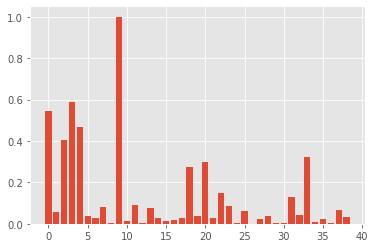

In [144]:
# 2. feature processing
import scipy.stats as stats
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, plot_confusion_matrix

df_train = pd.read_csv("data/train.csv", index_col=0).to_numpy()
df_valid = pd.read_csv("data/valid.csv", index_col=0).to_numpy()
X_train, y_train = df_train[:, :-1], df_train[:, -1]
X_valid, y_valid = df_valid[:, :-1], df_valid[:, -1]

# numerical_features = list(range(8))
numerical_features = list(range(8))+list(range(20, 24))
# numerical_features = list(range(len(X_train[0])))
preprocess_std = ColumnTransformer(
                            transformers = [('stand', StandardScaler(), numerical_features)], 
                            remainder="passthrough"
                            )

preprocess_minmax = ColumnTransformer(
                            transformers = [('minmax', MinMaxScaler(), numerical_features)], 
                            remainder="passthrough"
                            )

preprocess_maxabs = ColumnTransformer(
                            transformers = [('maxabs', MaxAbsScaler(), numerical_features)], 
                            remainder="passthrough"
                            )

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2
X_indices = np.arange(df_train.shape[-1]-1)
# selector = SelectKBest(f_classif, k=15)
selector = SelectKBest(chi2, k=15)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices, scores)
# plt.bar(X_indices, selector.pvalues_)

In [109]:
from sklearn.metrics import make_scorer
f1_macro_negative = make_scorer(f1_score, pos_label=0)

def custom(y_true, y_pred):
    tp = ((y_true==1) & (y_pred==1)).sum()
    tn = ((y_true==0) & (y_pred==0)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    # return fp / (tn + tp)
    # return fp
    if tp <= 100:
        return 100
    else: 
        return fp / (fp + tn)

score = make_scorer(custom, greater_is_better=False)

              precision    recall  f1-score   support

         0.0      0.230     0.723     0.349        94
         1.0      0.962     0.744     0.839       890

    accuracy                          0.742       984
   macro avg      0.596     0.734     0.594       984
weighted avg      0.892     0.742     0.792       984



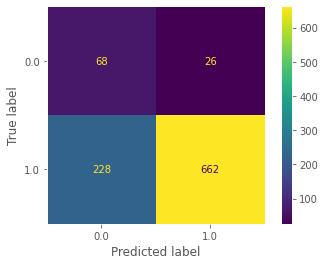

In [136]:
# 3. classify
# FP = network says survive=T but data says survive=F
# FN = network says survive=F but data says survive=T
# the goal is to minimize the FP, we don't want the model to "hide the sick patients"
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="lbfgs", class_weight="balanced")
pipe = Pipeline(steps=[
                    ('selection', selector), 
                    ('preprocess', StandardScaler()), 
                    # ('preprocess', preprocess_std), 
                    ('model', logreg)
                ])
pipe.fit(X_train, y_train)
y = pipe.predict(X_valid)

print(classification_report(y_valid, y, digits=3))
plot_confusion_matrix(pipe, X_valid, y_valid, normalize=None)
plt.grid(False)

# import math
# w = logreg.coef_[0]
# feature_importance = pd.DataFrame(df_feat.columns[:-1], columns=["features"])
# feature_importance["importance"] = pow(math.e, w)
# feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
# feature_importance

Fitting 2 folds for each of 100 candidates, totalling 200 fits


/home/dot/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1294).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


              precision    recall  f1-score   support

         0.0      0.147     0.926     0.254        94
         1.0      0.982     0.434     0.602       890

    accuracy                          0.481       984
   macro avg      0.565     0.680     0.428       984
weighted avg      0.902     0.481     0.568       984

Model rank: 1
Mean validation score: 0.340 (std: 0.005)
Parameters: {'model__C': 1, 'model__degree': 54, 'model__kernel': 'rbf', 'model__max_iter': 1294}

Model rank: 2
Mean validation score: 0.339 (std: 0.005)
Parameters: {'model__C': 1, 'model__degree': 75, 'model__kernel': 'rbf', 'model__max_iter': 1350}

Model rank: 3
Mean validation score: 0.338 (std: 0.007)
Parameters: {'model__C': 1, 'model__degree': 77, 'model__kernel': 'rbf', 'model__max_iter': 1139}



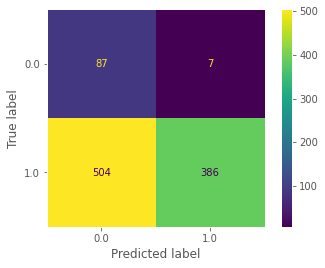

In [134]:
from sklearn.svm import SVC

hyperparams = {
    'model__C': stats.randint(1, 30),
    'model__kernel': ['rbf'],
    'model__degree': stats.randint(20, 80),
    'model__max_iter': stats.randint(500, 1500)
}

pipe = Pipeline(steps=[
                    ('selection', selector), 
                    ('preprocess', StandardScaler()), 
                    # ('preprocess', preprocess_std), 
                    ('model', SVC(class_weight="balanced"))
                ])
svc_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='f1_macro',
                            # scoring=score,
                            scoring=f1_macro_negative,
                            n_iter=100,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)
y = svc_rand.best_estimator_.predict(X_valid)

print(classification_report(y_valid, y, digits=3))
plot_confusion_matrix(svc_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(svc_rand.cv_results_, n_top=3)

# save and load
# dump(svc_rand.best_estimator_["model"], "models/svc_fp13.joblib")
# test = load("models/svc_fp13.joblib")

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
              precision    recall  f1-score   support

         0.0      0.253     0.617     0.359        94
         1.0      0.952     0.808     0.874       890

    accuracy                          0.790       984
   macro avg      0.603     0.712     0.617       984
weighted avg      0.886     0.790     0.825       984

Model rank: 1
Mean validation score: 0.382 (std: 0.024)
Parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 59}

Model rank: 2
Mean validation score: 0.379 (std: 0.015)
Parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 48}

Model rank: 3
Mean validation score: 0.378 (std: 0.006)
Parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 

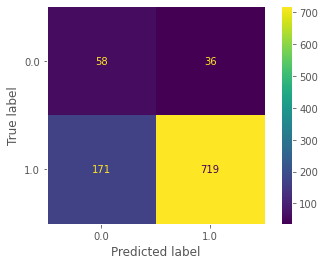

In [135]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
    'model__n_estimators': stats.randint(30, 60),
    'model__criterion': ('gini', 'entropy'),
    'model__max_depth': stats.randint(1, 20),
    'model__min_samples_split': stats.randint(2, 10),
    'model__min_samples_leaf': stats.randint(1, 5),
    'model__max_features': ('sqrt', 'log2'),
}

# pipe = Pipeline(steps=[('model', RandomForestClassifier(class_weight="balanced"))])
# pipe = Pipeline(steps=[('preprocess', preprocess_std), ('model', RandomForestClassifier(class_weight="balanced"))])
pipe = Pipeline(steps=[
                    ('selection', selector), 
                    ('preprocess', StandardScaler()), 
                    ('model', RandomForestClassifier(class_weight="balanced"))
                ])
rf_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='precision',
                            scoring=f1_macro_negative,
                            # scoring="f1_macro",
                            # scoring=score,
                            n_iter=500,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)
y = rf_rand.best_estimator_.predict(X_valid)

print(classification_report(y_valid, y, digits=3))
plot_confusion_matrix(rf_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)

report(rf_rand.cv_results_)

# feature importance use permutation importance
# importance = rf_rand.best_estimator_["model"].feature_importances_
# plt.bar(list(range(len(importance))), importance)

# save and load
# dump(rf_rand.best_estimator_["model"], "models/rf_fp33_fn204_customscore.joblib")
# test = load("models/svc_fp13.joblib")

In [141]:
# from sklearn.neural_network import MLPClassifier

# pipeline = Pipeline([('estimator', MLPClassifier())])

# hyperparams = {
#     'estimator__hidden_layer_sizes': stats.randint(10, 50),
#     # 'estimator__activation': ('logistic', 'tanh', 'relu'),
#     'estimator__solver': ('lbfgs', 'sgd', 'adam'),
#     'estimator__learning_rate_init': stats.uniform(0.001, 0.01),
#     # 'estimator__alpha': stats.uniform(),
#     'estimator__max_iter': stats.randint(25, 200),
# }

# nn_rand = RandomizedSearchCV(pipeline,
#                             param_distributions=hyperparams,
#                             scoring='f1_macro',
#                             n_iter=200,
#                             cv=2,
#                             n_jobs=-1,  # use all processors
#                             refit=True,  # refit the best model at the end
#                             return_train_score=True,
#                             verbose=True).fit(X_train, y_train)

# y = nn_rand.best_estimator_.predict(X_valid)
# print(classification_report(y_valid, y, digits=3))
# plot_confusion_matrix(nn_rand.best_estimator_, X_valid, y_valid, normalize=None)
# plt.grid(False)